pip install selenium

In [5]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [6]:
from selenium import webdriver
from bs4 import BeautifulSoup as Soup
import time
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime

In [16]:
ranges = pd.read_excel('Ranges.xlsx').to_dict()
info = []
driver = webdriver.Chrome("chromedriver.exe")

C:\Users\karin\AppData\Local\Temp/ipykernel_17940/2939310640.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("chromedriver.exe")


In [18]:
for j in range(len(ranges)):
    low =ranges["low"][j]
    high = ranges["high"][j]
    for i in range(50):
        url = f"https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&maxprice={high}&minprice={low}&offer_type=flat&region=1&room1=1&room2=1&room3=1&room4=1&room5=1&room6=1&room7=1&room9=1&type=4&p={i}"
        driver.get(url)
        html = driver.page_source
        soup = Soup(html)
        articles = soup.find_all("div",{"data-testid":"offer-card"})
        for article in articles:
            d = {}
            try:
                d['title'] = article.find("span",{"data-mark":"OfferTitle"}).text
            except Exception:
                None
            try:
                d['cars'] = article.find("span",{"data-mark":"OfferSubtitle"}).text
            except Exception:
                None
            try:
                d['metro'] = article.find("div",{"data-name":"SpecialGeo"}).find_all("div")[-2].text
            except Exception:
                None
            try:
                d['dist'] = article.find("div",{"data-name":"SpecialGeo"}).find_all("div")[-1].text
            except Exception:
                None
            try:
                d['address'] = "; ".join([x.text for x in article.find_all("a",{"data-name":"GeoLabel"})])
            except Exception:
                None
            try:
                d['price'] = article.find("span",{"data-mark":"MainPrice"}).text
            except Exception:
                None
            try:
                d['price_info'] = article.find("p",{"data-mark":"PriceInfo"}).text.replace("\xa0","")
            except Exception:
                None
            try:
                d['description'] = article.find("div",{"data-name":"Description"}).text
            except Exception:
                None
            try:
                d['url'] = article.find("div",{"data-name":"LinkArea"}).find("a").get("href")
            except Exception:
                None
            try:
                d['date'] = article.find("div",{"data-name":"TimeLabel"}).find_all("span")[-1].text
            except Exception:
                None
            try:
                d['phone'] = article.find("button",{"data-mark":"PhoneButton"}).text
            except Exception:
                None
            try:
                d['user_type'] = article.find("div",{"data-name":"BrandingLevelWrapper"}).find_all("span")[1].text
                d['user'] = article.find("div",{"data-name":"BrandingLevelWrapper"}).find_all("span")[2].text
                d['user_url'] = article.find("div",{"data-name":"BrandingLevelWrapper"}).find("a").get("href")
            except Exception:
                None
            info.append(d)

KeyboardInterrupt: 

Запоминаем наши данные

In [ ]:
df.to_excel('07-04-2023_v4.xlsx')

In [180]:
df = pd.DataFrame(info)
df = df.drop_duplicates(subset=["url"]).reset_index(drop=True)
df["date"] = df["date"].str.replace("сегодня","7 апр").replace("вчера","6 апр",regex=True)
df[["duration","utilities","commission","deposit"]] = df["price_info"].str.split(",",expand=True)
df["price"] = df["price"].str.replace("₽/мес.","",regex=True).replace(r"\s","",regex=True).astype("int")
df["commission"] = (df["commission"].str.extract(r'комиссия (\d+)%').fillna(0).astype("int")/100)[0]*df["price"]
df["rooms"] = df["cars"].str.extract(r'(\d*)-комн')[0]
df.loc[df["rooms"].isna(),"rooms"] = df["title"].str.extract(r'(\d*)-комн')[0]
df["rooms"] = df["rooms"].astype("Int64")
df["meters"] = df["cars"].str.split(", ",expand=True)[1].replace({r"\s*м²":"",r",":"."},regex=True).astype("float")
df.loc[df["meters"].isna(),"meters"] = df[df["meters"].isna()]["title"].str.split(", ",expand=True)[1].replace({r"\s*м²|\s*":"",r",":"."},regex=True).astype("float")
df[["apt_floor","max_floor"]] = df["cars"].str.split(", ",expand=True)[2].str.extract(r'(\d+)[/](\d+)')
df["okrug"] = df["address"].str.split(";",expand=True)[2].str.extract(r'(\w+АО)$')[0]
df.loc[df["okrug"].isna(),"okrug"] = df["address"].str.split(";",expand=True)[1].str.extract(r'(\w+АО)\s?')[0][df["okrug"].isna()]
df["deposit"] = df["deposit"].str.replace(r'без залога',"0₽").str.replace('\s*залог\s+|\s*',"",regex=True)
df["depo_curr"] = df["deposit"].str.extract(r'(\D+)')[0]
df["deposit"] = df["deposit"].str.extract(r'(\d+)').astype("int")[0]
df.loc[df["depo_curr"] == '€',"deposit"]*=90
df.loc[df["depo_curr"] == '$',"deposit"]*=80
df.drop("depo_curr",axis=1,inplace=True)

In [176]:
df["district"] = df["address"].str.split(";",expand=True)[2].str.extract(r'^\s*р-н\s*([\w\W]+)\s*')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[3].str.extract(r'^\s*р-н\s*([\w\W]+)\s*')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[2].str.extract(r'(\w*\s*поселение\s*\w*)')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[3].str.extract(r'(\w*\s*поселение\s*\w*)')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[2].str.extract(r'([Пп]ос[.]\s*\w*)')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[3].str.extract(r'([Пп]ос[.]\s*\w*)')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[2].str.extract(r'(\w*\s*[Мм]осковский$)')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[3].str.extract(r'(\w*\s*[Мм]осковский$)')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[2].str.extract(r'^\s?(Щербинка|Кокошкино|Троицк|Киевский)')[0]
df.loc[df["district"].isna(),"district"] = df.loc[df["district"].isna(),"address"].str.split(";",expand=True)[3].str.extract(r'^\s?(Щербинка|Кокошкино|Троицк|Киевский)')[0]
df.loc[df["district"] == "Пресненский","district"] = "Москва-Сити"
df.loc[(~df["address"].str.contains(r"[Пп]ресненская|1-й Красногвардейский",regex=True).fillna(False))&(df["district"] == "Москва-Сити"),"district"] = "Пресненский (вне Москвы-Сити)"
df.loc[~(df["dist"].str.contains(r'минут').fillna(False)),"dist"] = None
df["way"] = df["dist"].str.extract(r'минут[ыа]?\s*([\w\s]*)')[0]
df["dist"] = df["dist"].str.extract("(\d+)")[0].astype("Int64")
df.loc[df["way"] == "на транспорте","dist"]*=8
df.drop("way",axis=1,inplace=True)
df.loc[df["utilities"] == " комм. платежи включены (счётчики включены)","util_price"] = 0
df.loc[df["utilities"].str.contains(r'[+]'),"util_price"] = 0
df.loc[df["utilities"] == " комм. платежи включены (без счётчиков)","util_price"] = df.loc[df["utilities"] == " комм. платежи включены (без счётчиков)","meters"]*100
df.loc[df["utilities"] == " комм. платежи не включены","util_price"] = df.loc[df["utilities"] == " комм. платежи не включены","meters"]*200
df["TPrice24M"] = (df['price']+df["util_price"])*24+df['deposit']+df['commission']
df["TPrice24MPM"] = df["TPrice24M"]/df["meters"]
df.loc[df["meters"]>1500,"meters"]/=1000

Запоминаем эти данные

In [ ]:
df.to_excel('07-04-2023_v4.xlsx')

При перезапуске вспоминаем

In [7]:
df = pd.read_excel('07-04-2023_v4.xlsx',index_col=0)

<Axes: xlabel='okrug'>

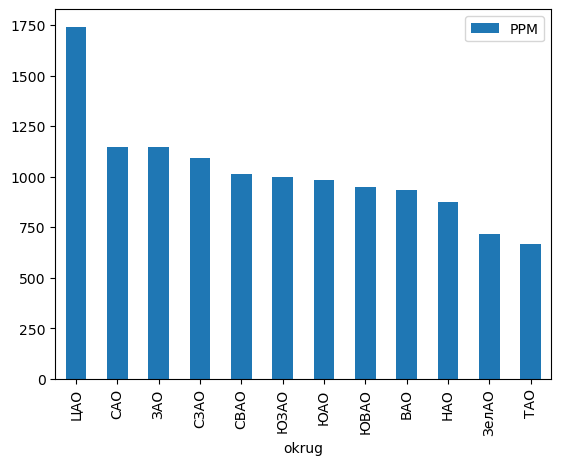

In [4]:
df.groupby("okrug").agg({"PPM":"median"}).sort_values(by="PPM",ascending=False).plot(kind="bar")

<Axes: xlabel='okrug'>

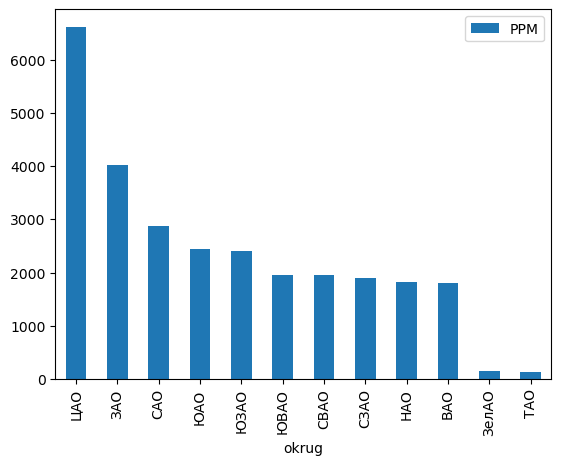

In [5]:
df.groupby("okrug").agg({"PPM":"count"}).sort_values(by="PPM",ascending=False).plot(kind="bar")

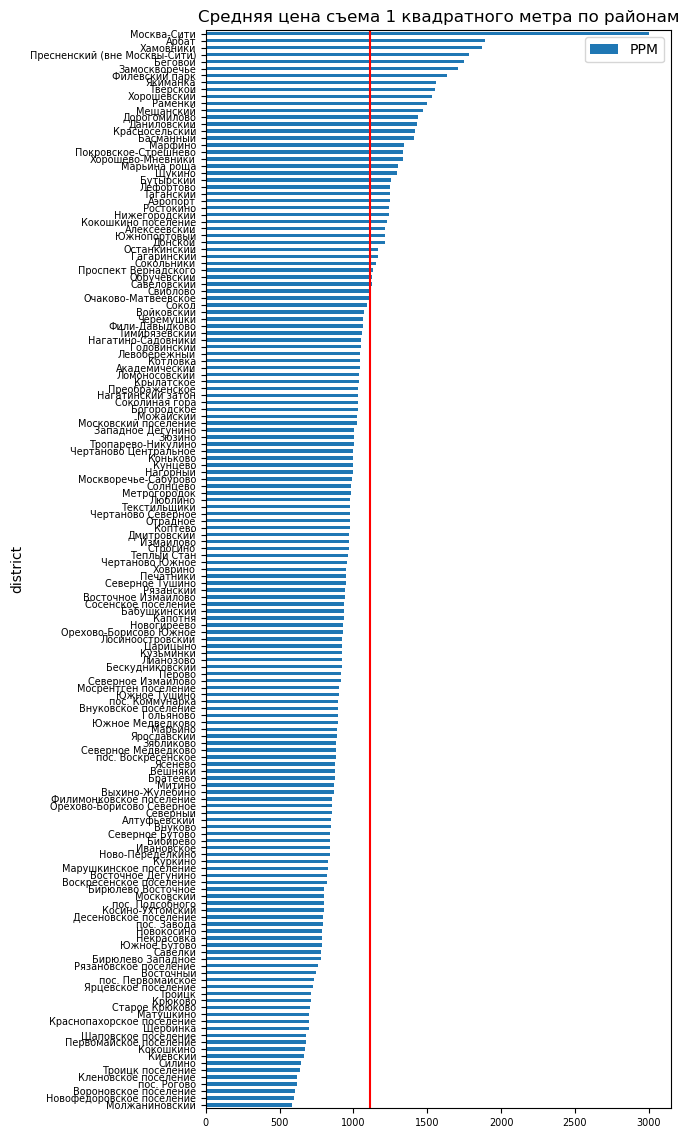

In [6]:
fig,ax = plt.subplots()
df.groupby("district").agg({"PPM":"median"}).sort_values(by="PPM",ascending=True).plot(ax=ax,kind="barh",figsize=(6,14),fontsize=7,title="Средняя цена съема 1 квадратного метра по районам")
ax.axvline(df["PPM"].median(),color="red");

<Axes: title={'center': 'Средняя цена съема 1 квадратного метра по районам'}, ylabel='district'>

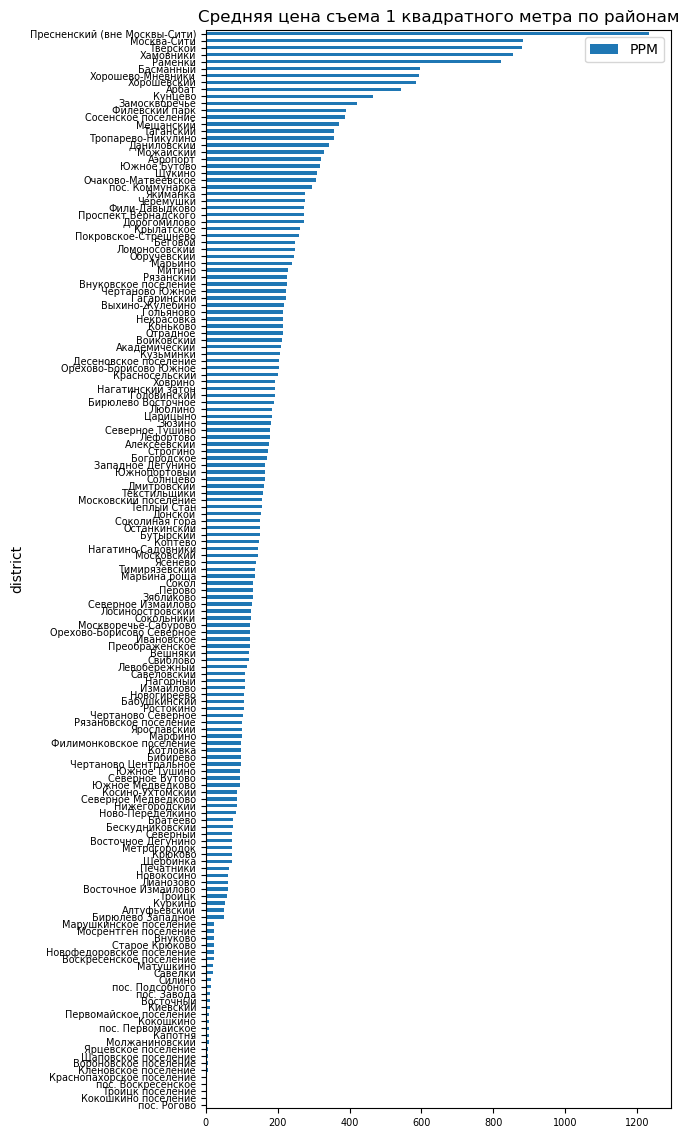

In [65]:
df.groupby("district").agg({"PPM":"count"}).sort_values(by="PPM",ascending=True).plot(kind="barh",figsize=(6,14),fontsize=7,title="Средняя цена съема 1 квадратного метра по районам")

<Axes: ylabel='district'>

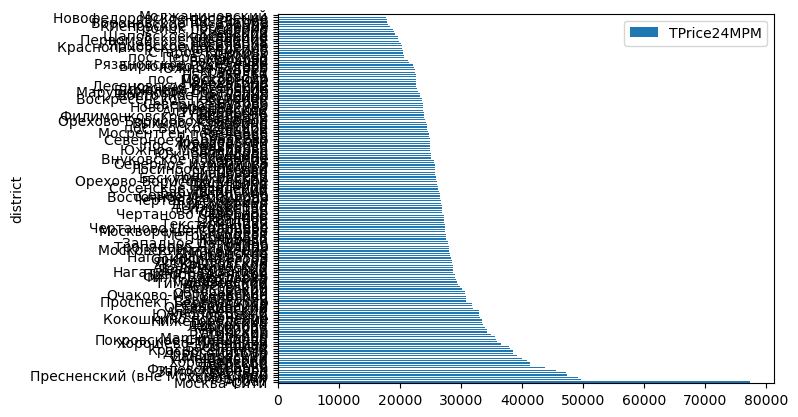

In [62]:
df.groupby('district').agg({"TPrice24MPM":'median'}).sort_values(by="TPrice24MPM").plot(kind="barh",figsize=(6,14))

In [ ]:
df[df["rooms"]>=2].groupby("district").apply(lambda x: x.nsmallest(10,["TPrice24MPM","dist"])).loc["Гагаринский"]